# Form factor of a two-boson bound state

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import math as m
from numpy.polynomial.legendre import leggauss
from scipy.special import legendre
from functions import * #Import the functions given in the lecture
        

In [46]:
Lambda = [300+i*100 for i in range(0, 10)]
C0 = [-9.827953*1e-2, -2.820315*1e-02,  -4.221894*1e-04, 1.285743*1e-02,
      2.016719*1e-02,  2.470795*1e-02, 2.786520*1e-02,  3.030801*1e-02,
     3.239034*1e-02,  3.431611*1e-02]
nx =20
mpi = 138
A = -0.1544435
E = -2.225*5.06*1e-3
neigv = 1
cutoff=Lambda
pot = OBEpot(nx=nx,mpi=mpi,C0=C0[0],A=A,cutoff=Lambda[0])
solver=TwoBody(pot=pot, np1=40,np2=20,pa=1.0,pb=7.0,pc=8.0,mred=938.92/2,l=0,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)

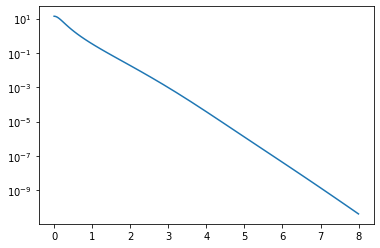

In [47]:
import matplotlib.pyplot as plt

plt.plot(solver.eigv(E, neigv)[1],solver.eigv(E, neigv)[-1])
plt.yscale('log')


In [41]:
solver.eigv(E, neigv)[-1]

array([1.38310531e+01+0.j, 1.38233629e+01+0.j, 1.37829694e+01+0.j,
       1.36643380e+01+0.j, 1.34043611e+01+0.j, 1.29317391e+01+0.j,
       1.21864132e+01+0.j, 1.11465130e+01+0.j, 9.85012972e+00+0.j,
       8.39456916e+00+0.j, 6.90774339e+00+0.j, 5.50774241e+00+0.j,
       4.27423544e+00+0.j, 3.24214677e+00+0.j, 2.41149406e+00+0.j,
       1.76204253e+00+0.j, 1.26540118e+00+0.j, 8.92477480e-01+0.j,
       6.17074801e-01+0.j, 4.17102793e-01+0.j, 2.74587543e-01+0.j,
       1.75201982e-01+0.j, 1.07677418e-01+0.j, 6.32449199e-02+0.j,
       3.51525944e-02+0.j, 1.82654992e-02+0.j, 8.74407830e-03+0.j,
       3.79300233e-03+0.j, 1.46509693e-03+0.j, 4.96150775e-04+0.j,
       1.46007927e-04+0.j, 3.75109189e-05+0.j, 8.62072084e-06+0.j,
       1.85232907e-06+0.j, 3.93259160e-07+0.j, 8.75362180e-08+0.j,
       2.18691850e-08+0.j, 6.66134594e-09+0.j, 2.70816946e-09+0.j,
       1.59267476e-09+0.j, 1.00373267e-09+0.j, 2.41433200e-10+0.j,
       1.87751325e-11+0.j, 4.89206166e-13+0.j, 4.52233232e-15+